### Import Packages

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import torchsummary
from alive_progress import alive_bar

### Global attributes

In [2]:
mixed_dir = {
    'machine': '../machine/mixed/',
    'nature': '../nature/mixed/',
    'human': '../human/mixed/'
}

clean_dir = {
    'machine': '../machine/clean/',
    'nature': '../nature/clean/',
    'human': '../human/clean/'
}

test_dir = {
    'input': '../test_data/',
    'output': '../test_output/',
    'visual': '../visualization/'
}

### Preprocess Data

In [3]:
# MelSpectrogram參數
n_mels = 128                # 保持 Mel 頻譜圖的解析度
n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
hop_length = 512            # 保持 hop_length 為 n_fft 的一半
win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
sample_rate = 16000         # 採樣率保持不變，適合語音處理
f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
duration = 5                # 音頻時長為 5 秒

In [4]:
def load_spectrogram_from_npy(mixed_dir, clean_dir = None):
    """Load mel spectrogram from a NumPy file."""
    mixed_mel_spectrograms = []
    clean_mel_spectrograms = []
    
    length = len(os.listdir(mixed_dir))
    
    print(f"Loading {length} files...")

    with alive_bar(length, force_tty=True) as bar:
        for filename in sorted(os.listdir(mixed_dir)):
            if ".gitkeep" in filename:
                continue
            try:
                # 使用完整路徑
                mixed_path = os.path.join(mixed_dir, filename)
                if (clean_dir != None): clean_path = os.path.join(clean_dir, filename)
                
                mixed_mel_spectrogram_db = np.load(mixed_path)
                if (clean_dir != None): clean_mel_spectrogram_db = np.load(clean_path)

                # # 轉換為 PyTorch tensor 並添加通道維度
                mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                if (clean_dir != None): clean_mel_tensor = torch.tensor(clean_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                
                mixed_mel_spectrograms.append(mixed_mel_tensor)
                if (clean_dir != None): clean_mel_spectrograms.append(clean_mel_tensor)
                
                bar()
                
            except Exception as e:
                print(f"Error load file {filename}: {str(e)}")
                continue

    if (clean_dir != None): return mixed_mel_spectrograms, clean_mel_spectrograms
    else: return mixed_mel_spectrograms

In [5]:
machine_mixed_mel_spectrograms, machine_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['machine'], clean_dir['machine'])
nature_mixed_mel_spectrograms, nature_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['nature'], clean_dir['nature'])
human_mixed_mel_spectrograms, human_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['human'], clean_dir['human'])
test_mixed_mel_spectrograms = load_spectrogram_from_npy(test_dir['input'])
mixed_mel_spectrograms = machine_mixed_mel_spectrograms + nature_mixed_mel_spectrograms + human_mixed_mel_spectrograms
clean_mel_spectrograms = machine_clean_mel_spectrograms + nature_clean_mel_spectrograms + human_clean_mel_spectrograms
target_dim = 160
pad_width = [(0, 0), (0, 0), (0, target_dim - mixed_mel_spectrograms[0].shape[2])]
mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in mixed_mel_spectrograms]
clean_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in clean_mel_spectrograms]
test_mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in test_mixed_mel_spectrograms]
mixed_mel_spectrograms_train, mixed_mel_spectrograms_val, clean_mel_spectrograms_train, clean_mel_spectrograms_val = train_test_split(mixed_mel_spectrograms, clean_mel_spectrograms, test_size=0.2, random_state=42)
time_steps = mixed_mel_spectrograms[0].shape[2]

Loading 7500 files...
|████████████████████████████████████████| 7500/7500 [100%] in 3:08.8 (39.71/s)  █▆▄ 511/7500 [7%] in 10s (~2:20, 48.7 ▁▃▅ 540/7500 [7%] in 11s (~2:20, 49.2 ▃▁▃ 2682/7500 [36%] in 1:02 (~1:50, 4 ▃▅▇ 3241/7500 [43%] in 1:15 (~1:30, 4 ▂▄▆ 3867/7500 [52%] in 1:29 (~1:20, 4 █▆▄ 3979/7500 [53%] in 1:31 (~1:20, 4 ▅▃▁ 4453/7500 [59%] in 1:40 (~1:00, 4 ▇▇▅ 4649/7500 [62%] in 1:45 (~1:00, 4 ▆▄▂ 4798/7500 [64%] in 1:50 (~1:00, 4 ▆█▆ 5015/7500 [67%] in 1:58 (~58s, 42 ▁▃▅ 5070/7500 [68%] in 1:59 (~57s, 42 ▃▅▇ 5159/7500 [69%] in 2:02 (~55s, 42 ▃▁▃ 5215/7500 [70%] in 2:04 (~54s, 42 ▅▇▇ 5295/7500 [71%] in 2:06 (~52s, 42 ▂▂▄ 5662/7500 [75%] in 2:17 (~44s, 41 ▄▆█ 5770/7500 [77%] in 2:21 (~42s, 40 ▄▂▂ 5892/7500 [79%] in 2:24 (~39s, 40 ▅▇▇ 6136/7500 [82%] in 2:30 (~33s, 41 ▄▆█ 6191/7500 [83%] in 2:31 (~32s, 40 ▆█▆ 6321/7500 [84%] in 2:34 (~29s, 40 ▂▂▄ 6663/7500 [89%] in 2:45 (~21s, 40 ▂▂▄ 6980/7500 [93%] in 2:54 (~13s, 40
Loading 7500 files...
|██████████████████████████████████████

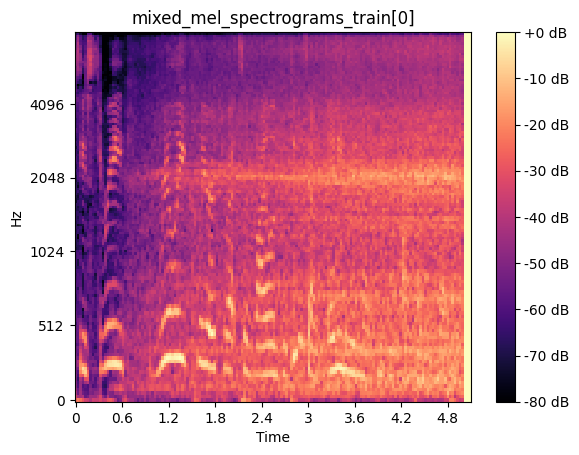

In [6]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mixed_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='mixed_mel_spectrograms_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "mixed_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

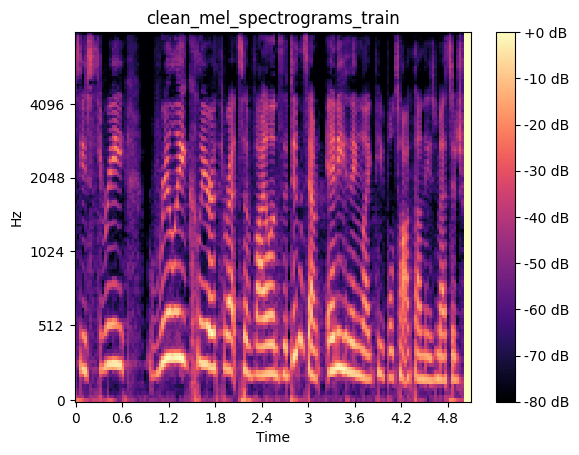

In [7]:
fig, ax = plt.subplots()
img = librosa.display.specshow(clean_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='clean_mel_spectrograms_train')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "clean_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Training

In [9]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # 全連接層 ### shape 有問題
        self.fc1 = nn.Linear(10240, 256)  # 假設輸入大小為 (1, 64, 64)
        self.fc2 = nn.Linear(256, 10240)

        # 解碼器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # 編碼器
        x = self.encoder(x)
        
        # 將特徵展平
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # 全連接層處理
        x = self.fc1(x)
        x = self.fc2(x)
        
        # 恢復形狀為解碼器輸入
        x = x.view(batch_size, 128, 8, 10)
        # 解碼器
        x = self.decoder(x)
        return x

In [13]:
# Model參數
num_epochs = 15
batch_size = 256
learning_rate = 0.5
lr_decay_step = 20
lr_decay_gamma = 0.6

In [11]:
class AudioDataset(Dataset):
    def __init__(self, mixed_data, clean_data):
        self.mixed = mixed_data
        self.clean = clean_data
    
    def __len__(self):
        return len(self.mixed)
    
    def __getitem__(self, idx):
        return self.mixed[idx], self.clean[idx]

dataset = AudioDataset(mixed_mel_spectrograms_train, clean_mel_spectrograms_train)
dataloader = DataLoader(dataset, batch_size=batch_size)
dataloader_val = DataLoader(AudioDataset(mixed_mel_spectrograms_val, clean_mel_spectrograms_val), batch_size=len(mixed_mel_spectrograms_val))


In [14]:
from torch.optim.lr_scheduler import StepLR
model = DenoiseAutoencoder()

# torchsummary.summary(model,(1,64,44))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)
training_losses = []
valdation_losses = []

# 訓練過程
for epoch in range(num_epochs):
    model.train()
    for (mixed, clean) in dataloader:
        
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(mixed)
        loss = criterion(outputs, clean)
            
        # 反向傳播和優化
        loss.backward()
        optimizer.step()
        
    # Step the scheduler to decay the learning rate
    scheduler.step()
    
    # count validation loss
    val_output = model(next(iter(dataloader_val))[0])
    val_loss = criterion(val_output, next(iter(dataloader_val))[1])
    valdation_losses.append(val_loss.item())
    
    training_losses.append(loss.item())
    # Optionally, print the current learning rate and loss
    current_lr = scheduler.get_last_lr()[0]
    if (epoch > 5): print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.12f}, Validation Loss: {val_loss.item():.12f}, Learning Rate: {current_lr:.8f}")

Epoch [7/15], Training Loss: 32.631584167480, Validation Loss: 32.804813385010, Learning Rate: 0.50000000
Epoch [8/15], Training Loss: 26.921533584595, Validation Loss: 27.404460906982, Learning Rate: 0.50000000
Epoch [9/15], Training Loss: 23.461437225342, Validation Loss: 23.997213363647, Learning Rate: 0.50000000
Epoch [10/15], Training Loss: 20.919736862183, Validation Loss: 21.813709259033, Learning Rate: 0.50000000
Epoch [11/15], Training Loss: 19.204338073730, Validation Loss: 19.946008682251, Learning Rate: 0.50000000
Epoch [12/15], Training Loss: 17.611772537231, Validation Loss: 18.795578002930, Learning Rate: 0.50000000
Epoch [13/15], Training Loss: 16.362083435059, Validation Loss: 17.237289428711, Learning Rate: 0.50000000
Epoch [14/15], Training Loss: 15.348548889160, Validation Loss: 16.166276931763, Learning Rate: 0.50000000
Epoch [15/15], Training Loss: 14.491970062256, Validation Loss: 15.277028083801, Learning Rate: 0.50000000


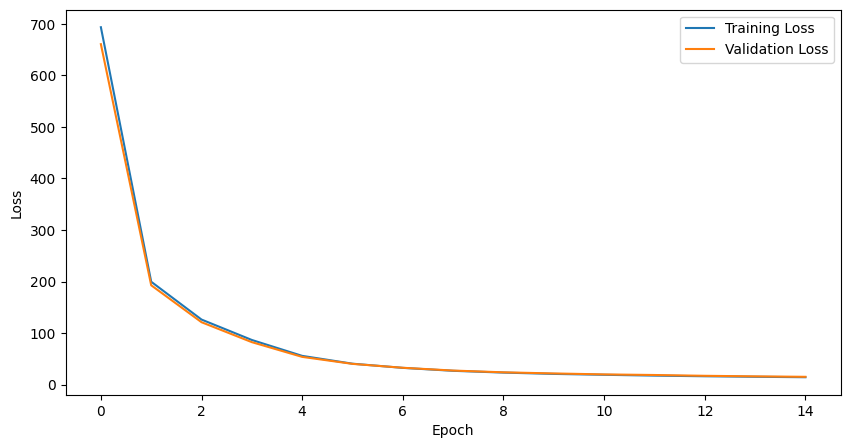

In [15]:
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(valdation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "training_loss.png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

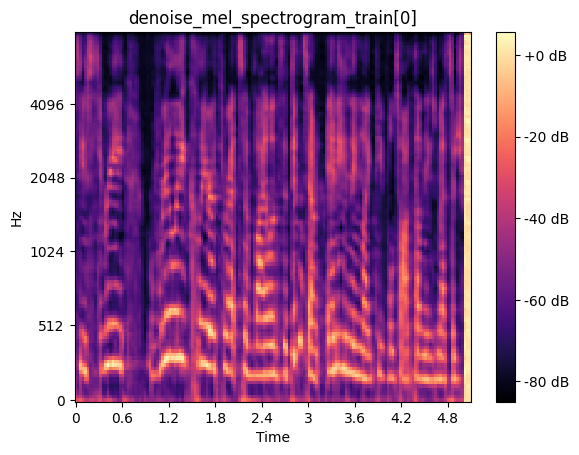

In [ ]:
model.eval()
# 這行超久要怎麼解
denoised_output = model(torch.from_numpy(mixed_mel_spectrograms_train[0]).unsqueeze(0))
fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output.squeeze(0).squeeze(0).detach().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='denoise_mel_spectrogram_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "denoise_mel_spectrogram_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Prediction

In [ ]:
# MelSpectrogram參數 (勿動)
n_mels = 128                # 保持 Mel 頻譜圖的解析度
n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
hop_length = 512            # 保持 hop_length 為 n_fft 的一半
win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
sample_rate = 16000         # 採樣率保持不變，適合語音處理
f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
duration = 5                # 音頻時長為 5 秒

In [ ]:
# CLEAN
clean_waveform, sr = librosa.load('test_clean.wav', sr=sample_rate)

if sr != sample_rate:
    clean_waveform = librosa.resample(clean_waveform, orig_sr=sr, target_sr=sample_rate)

clean_mel_spectrogram = librosa.feature.melspectrogram(
    y=clean_waveform,
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

clean_mel_spectrogram_db = librosa.power_to_db(
    clean_mel_spectrogram, 
    ref=np.max, 
    amin=1e-10  # 避免log(0)
)

clean_mel_tensor = torch.tensor(clean_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)

clean_mel = clean_mel_tensor
clean_output = clean_mel.squeeze(0).squeeze(0).detach().numpy()
clean_output = librosa.db_to_power(clean_output)

audio_signal = librosa.feature.inverse.mel_to_audio(clean_output, sr=sample_rate, n_iter=500)
audio_signal = audio_signal / np.max(np.abs(audio_signal))


librosa.display.waveshow(audio_signal, sr=sample_rate)
soundfile.write('test_librosa_clean.wav', audio_signal, sample_rate)

In [ ]:
# MIXED
mixed_waveform, sample_rate = librosa.load('test2.wav', sr=sample_rate)

# if sr != sample_rate:
#     mixed_waveform = librosa.resample(mixed_waveform, orig_sr=sr, target_sr=sample_rate)
    
# cut to fit the duration
if len(mixed_waveform) > sample_rate * duration:
    mixed_waveform = mixed_waveform[:sample_rate * duration]

mixed_mel_spectrogram = librosa.feature.melspectrogram(
    y=mixed_waveform,
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

mixed_mel_spectrogram_db = librosa.power_to_db(
    mixed_mel_spectrogram, 
    ref=np.max, 
    amin=1e-10  # 避免log(0)
)

# mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram, dtype=torch.float32).squeeze().unsqueeze(0)
# mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
mixed_mel_tensor = torch.tensor(np.load('nature_mixed.npy'), dtype=torch.float32).squeeze().unsqueeze(0)

mixed_mel = mixed_mel_tensor
mixed_output = mixed_mel.squeeze(0).squeeze(0).detach().numpy()
mixed_output = librosa.db_to_power(mixed_output)

audio_signal = librosa.feature.inverse.mel_to_audio(
    mixed_output,
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_iter=4096
)

audio_signal = audio_signal / np.max(np.abs(audio_signal))


librosa.display.waveshow(audio_signal, sr=sample_rate)
soundfile.write('test_librosa_mixed.wav', audio_signal, sample_rate)

In [ ]:
# DENOISED
model.eval()  # 设置模型为评估模式
print(mixed_mel_tensor.shape)
mixed_mel_tensor = torch.tensor(np.pad(mixed_mel_tensor, pad_width=pad_width, mode='constant', constant_values=0), dtype=torch.float32)
denoised_output = model(mixed_mel_tensor.unsqueeze(0))
denoised_output = denoised_output.squeeze(0).squeeze(0).detach().numpy()
denoised_output = librosa.db_to_power(denoised_output)

audio_signal = librosa.feature.inverse.mel_to_audio(denoised_output, sr=sample_rate, n_iter=500)
audio_signal = audio_signal / np.max(np.abs(audio_signal))

librosa.display.waveshow(audio_signal, sr=sample_rate)
soundfile.write('test_librosa_denoised.wav', audio_signal, sample_rate)
